# **Clustering the Data**

## Objectives

* We will investigate the data using clustering algoritthms to investigate our hypothesis # something

## Inputs

* The game data from before the train test split at the beginning of notebook 04. 

## Outputs

* A clustering model and some analysis of the underlying data set.

## Additional Comments
* This notebook follow the analysis done in notebook 07 of the Churnometer walkthrough project.

---

# Change working directory
We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [16]:
import os

home_dir = '/workspace/pp5-ml-dashboard'
os.chdir(home_dir)
current_dir = os.getcwd()
print(current_dir)

/workspace/pp5-ml-dashboard


We now load our prepared data.

In [2]:
import pandas as pd
from src.utils import get_df, save_df

game_data = get_df('game_pre_split', 'datasets/clean/csv')

0

## Section 1: Set up problem
The game of basketball as evolved over the years. For example, we saw in our exploratory data analysis that there was a correlation between 3 pointers and year. We are going to test if clustering will detect the various eras of basketball, or perhaps it will define new ones.

We will then look at the profiles of each cluster to see how it groups games of basketball and try to determine if these clusters have any correlation with time.



In [3]:
game_data.drop(labels=['season'],inplace=True,axis=1)
game_data.head()

,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,oreb_home,dreb_home,reb_home,ast_home,...,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,home_wins,play_off
0,41,92,0,3,9,18,16,28,44,25,...,29,40,21,11,7,17,19,100,0,0
1,39,88,0,2,26,41,20,28,48,17,...,31,42,19,7,7,18,32,108,0,0
2,39,88,0,1,40,49,17,40,57,23,...,28,41,27,10,7,20,32,116,1,0
3,42,82,0,2,24,38,10,24,34,30,...,30,47,23,10,7,19,28,112,0,0
4,36,91,0,4,33,52,18,29,47,17,...,31,44,26,11,3,22,40,119,0,0


Now we construct our pipeline for clustering. The format for the pipeline was inspired by the clustering pipeline in the Churnometer walkthrough project.

In [4]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def cluster_pipe(thresh=0.7,p_components=50,clusters=50):
    pipe = Pipeline([
        ("corr_selector", SmartCorrelatedSelection(method="pearson",
                                                   threshold=thresh, 
                                                   selection_method="variance")),
        ("scaler", StandardScaler()),
        ("PCA", PCA(n_components=p_components, random_state=42)),
        ("model", KMeans(n_clusters=clusters, random_state=42)),
    ])
    return pipe

We will end up tuning the number of clusters and components as hyperparameters. It will be interesting to luck at how the analysis changes as we move between the number of clusters. At each stage, we will see how the function that assigns each game to its season behaves on clusters.

## Section 2: PCA
We start by doing some Principal component analysis.

In [5]:
# to suppress warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logging.captureWarnings(True)
os.environ['PYTHONWARNINGS']='ignore'

pipe = cluster_pipe()
pca_pipe = Pipeline(pipe.steps[:-2])
game_data_pca = pca_pipe.fit_transform(game_data)


We are now going to analyze the principal components. Feel free to adjust the number of components.

* The 15 components explain 97.95% of the data 



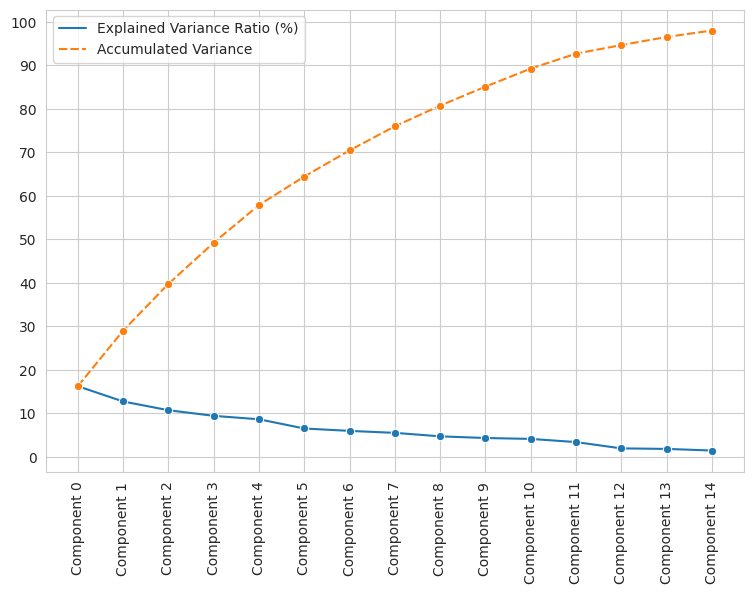

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# This function is from the notebook 07 of the 
# churnometer walkthrough project.
def pca_component_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)

    ComponentsList = [f"Component {number}"
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )
    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )
    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_component_analysis(game_data_pca, 15)


As we are hoping the data will be grouped into eras, each of which is multiple years long. We expect there to be a fair number of clusters, so we don't mind having many components.

* The 9 components explain 80.7% of the data 



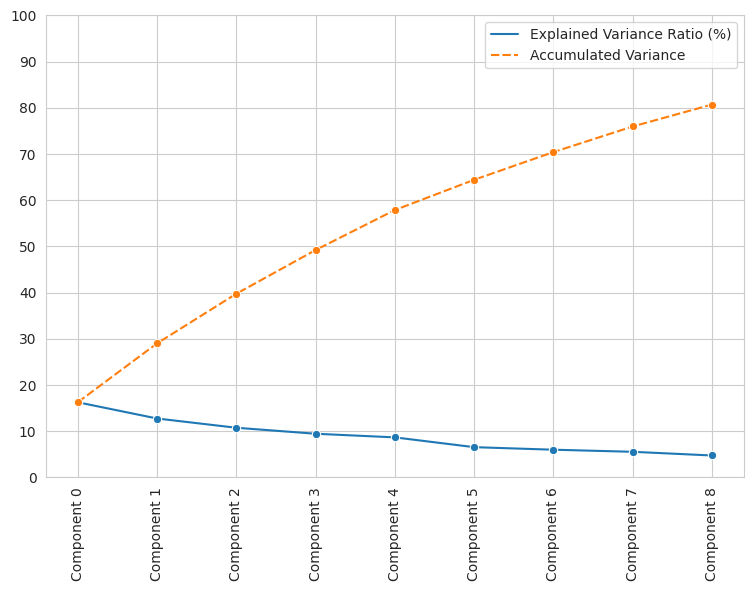

In [7]:
pca_component_analysis(game_data_pca,9)


So we redefine our pipeline creation function to have 9 as the number of components.

In [8]:
def cluster_pipe(thresh=0.7,clusters=50):
    pipe = Pipeline([
        ("corr_selector", SmartCorrelatedSelection(method="pearson",
                                                   threshold=thresh, 
                                                   selection_method="variance")),
        ("scaler", StandardScaler()),
        ("PCA", PCA(n_components=9, random_state=42)),
        ("model", KMeans(n_clusters=clusters, random_state=42)),
    ])
    return pipe

Now we need to use the elbow method and look at silhouette scores.

## Section 3: Elbow Method and Silhouette scores
These will help us determine the appropriate number of clusters to use for our algorithm. We are also taking into account some domain knowledge, which is that eras in basketball range from 6 to 10 years. It is not a well defined concept so we don't have a hard number. Our data set ranges from 1985 until 2022. So we (conservatively) expect there to be between 4 and 7 eras.

In [9]:
new_pipe = cluster_pipe()
pca_part_of_pipe = Pipeline(new_pipe.steps[:-1])
game_data_pca = pca_part_of_pipe.fit_transform(game_data)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


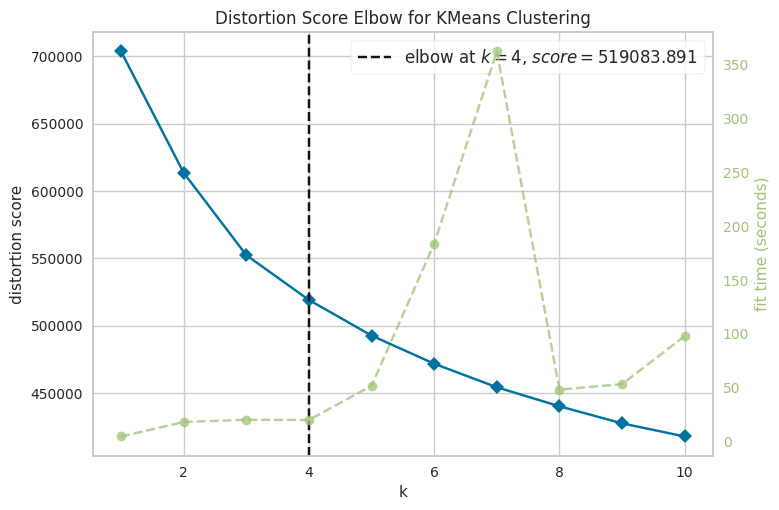

In [11]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(random_state=42), k=(1,11))
visualizer.fit(game_data_pca) 
visualizer.show() 
plt.show()

They are suggesting 4 clusters, but 6 also looks promising. Let's see how the Silhouette scores behave with respect to these different numbers of clusters.

=== Average Silhouette Score for different number of clusters ===


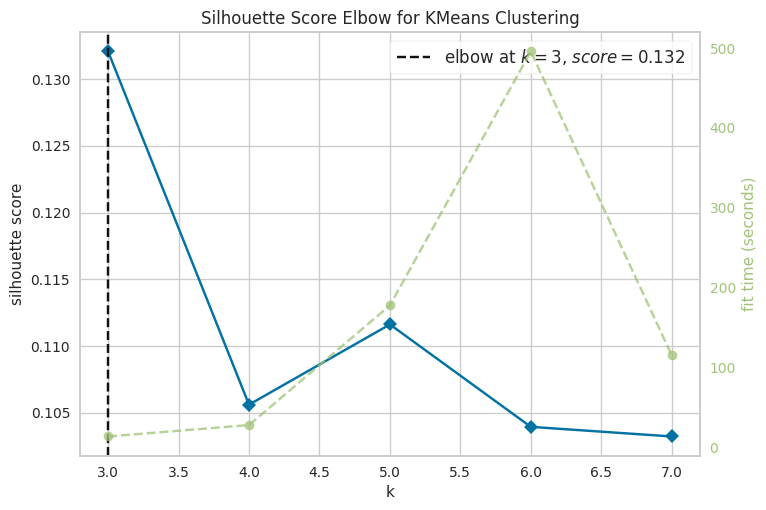



=== Silhouette plot for 3 Clusters ===


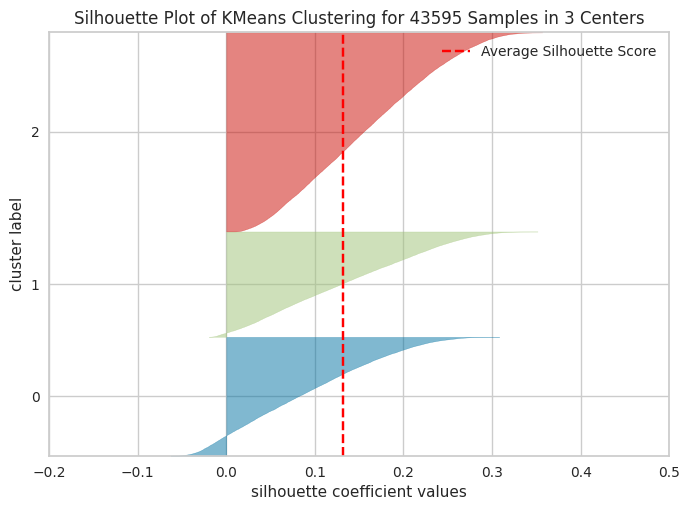



=== Silhouette plot for 4 Clusters ===


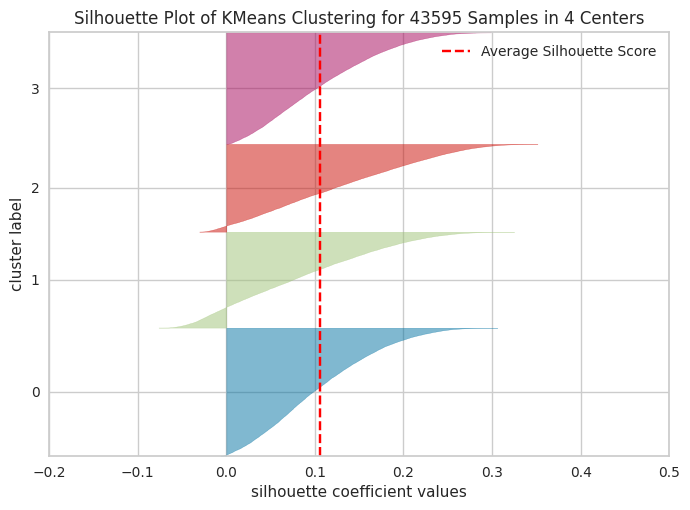



=== Silhouette plot for 5 Clusters ===


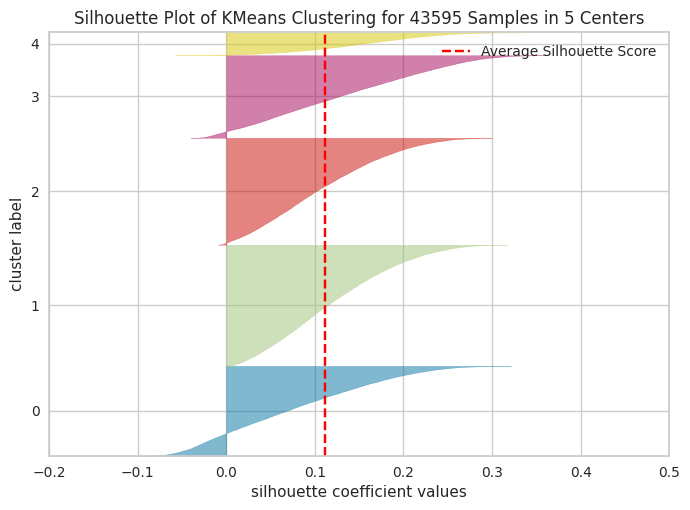



=== Silhouette plot for 6 Clusters ===


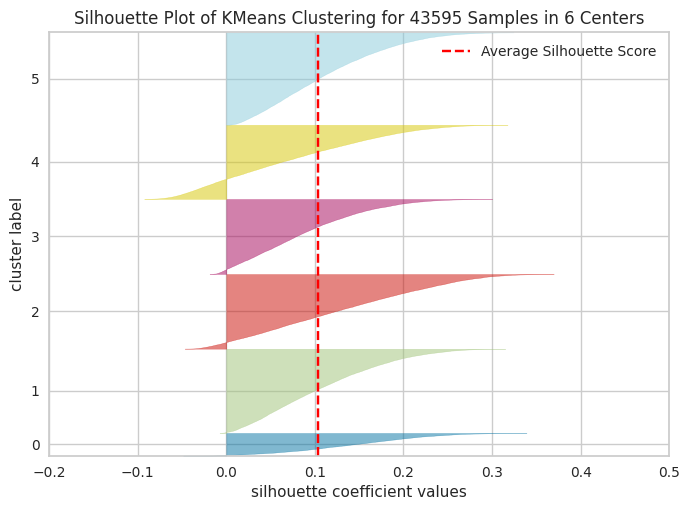



=== Silhouette plot for 7 Clusters ===


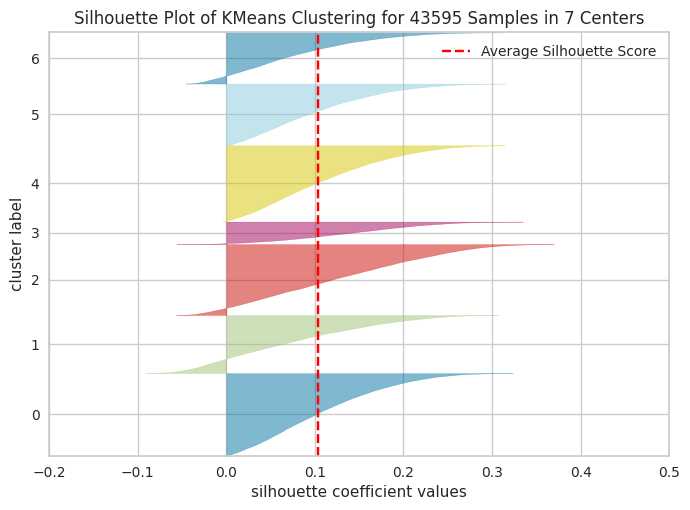

In [12]:
from yellowbrick.cluster import SilhouetteVisualizer

n_cluster_start = 3
n_cluster_stop = 8

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(game_data_pca)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters,
                                                       random_state=42),
                                      colors='yellowbrick')
    visualizer.fit(game_data_pca)
    visualizer.show()
    plt.show()
    print("\n")



The analysis suggest using 3 clusters. After adding the clustering data to the data frame we will see if the clustering correlates with the `season` feature.

In [10]:
pipe_w_clusters = cluster_pipe(clusters=3)
game_w_clusters = game_data.copy()
game_w_clusters.head()

,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,oreb_home,dreb_home,reb_home,ast_home,...,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,home_wins,play_off
0,41,92,0,3,9,18,16,28,44,25,...,29,40,21,11,7,17,19,100,0,0
1,39,88,0,2,26,41,20,28,48,17,...,31,42,19,7,7,18,32,108,0,0
2,39,88,0,1,40,49,17,40,57,23,...,28,41,27,10,7,20,32,116,1,0
3,42,82,0,2,24,38,10,24,34,30,...,30,47,23,10,7,19,28,112,0,0
4,36,91,0,4,33,52,18,29,47,17,...,31,44,26,11,3,22,40,119,0,0


Now we will fit both of these pipelines and see what they tell us.

In [11]:
pipe_w_clusters.fit(game_w_clusters)

Pipeline(steps=[('corr_selector',
                 SmartCorrelatedSelection(selection_method='variance',
                                          threshold=0.7,
                                          variables=['fgm_home', 'fga_home',
                                                     'fg3m_home', 'fg3a_home',
                                                     'ftm_home', 'fta_home',
                                                     'oreb_home', 'dreb_home',
                                                     'reb_home', 'ast_home',
                                                     'stl_home', 'blk_home',
                                                     'tov_home', 'pf_home',
                                                     'pts_home',
                                                     'plus_minus_home',
                                                     'fgm_away', 'fga_away',
                                                     'fg3m_away', 'fg3a_away',
   

In [12]:
game_data_w_seasons = get_df('game_pre_split', 'datasets/clean/csv')
def get_season(game_id):
    return game_data_w_seasons.loc[game_id, 'season']
    # ai suggested the above but I think it should be this one
    #return game_data_w_seasons.loc[game_id]['season']
game_test = game_w_clusters.copy()
for i in range(5):
    for _, row in game_test.iterrows():
        game_w_clusters.loc[_, 'season'] = get_season(row.name)


,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,oreb_home,dreb_home,reb_home,ast_home,...,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,home_wins,play_off
0,41,92,0,3,9,18,16,28,44,25,...,29,40,21,11,7,17,19,100,0,0
1,39,88,0,2,26,41,20,28,48,17,...,31,42,19,7,7,18,32,108,0,0
2,39,88,0,1,40,49,17,40,57,23,...,28,41,27,10,7,20,32,116,1,0
3,42,82,0,2,24,38,10,24,34,30,...,30,47,23,10,7,19,28,112,0,0
4,36,91,0,4,33,52,18,29,47,17,...,31,44,26,11,3,22,40,119,0,0


In [15]:
game_w_clusters['Clusters'] = pipe_w_clusters.predict(game_data)

game_w_clusters.head()

,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,oreb_home,dreb_home,reb_home,ast_home,...,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,home_wins,play_off,season,Clusters
0,41,92,0,3,9,18,16,28,44,25,...,21,11,7,17,19,100,0,0,0.0,2
1,39,88,0,2,26,41,20,28,48,17,...,19,7,7,18,32,108,0,0,0.0,0
2,39,88,0,1,40,49,17,40,57,23,...,27,10,7,20,32,116,1,0,0.0,0
3,42,82,0,2,24,38,10,24,34,30,...,23,10,7,19,28,112,0,0,0.0,0
4,36,91,0,4,33,52,18,29,47,17,...,26,11,3,22,40,119,0,0,0.0,0


* Cluster frequencies 
   Clusters
2      0.47
0      0.28
1      0.25 




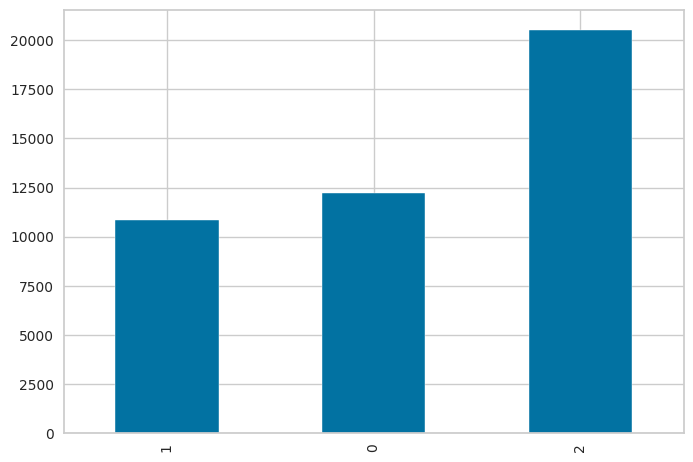

In [30]:
print(f"* Cluster frequencies \n{game_w_clusters['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
game_w_clusters['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

Let's investigate how the clusters and the components from the PCA relate to one another.

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style("whitegrid")


def compare_components_w_clusters(a:int,b:int,pca_step,cluster_step,pipe):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=pca_step[:, a], y=pca_step[:, b],
                hue=cluster_step['Clusters'], palette='Set1', alpha=0.6)
    plt.scatter(x=pipe['model'].cluster_centers_[:, 0],
            y=pipe['model'].cluster_centers_[:, 1],
            marker="x", s=169, linewidths=3, color="black")
    plt.xlabel(f"PCA Component {a}")
    plt.ylabel(f"PCA Component {b}")
    plt.title("PCA Components colored by Clusters")
    plt.show()

#pairs0 = [(0,b) for b in range(9) b!=0]
#print(len(pairs))
for b in range(9):
    compare_components_w_clusters(2, b, game_data_pca, game_w_clusters,
                                  pipe_w_clusters)
# interesting pairs
(0,1) 


KeyboardInterrupt: 